importing necessary libraries

In [7]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense  
from keras import applications 
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time
import os
import tensorflow as tf
import shutil

In [8]:
import pathlib
import zipfile
test1 = zipfile.ZipFile('Training_data/test1.zip')
test1.extractall()
train = zipfile.ZipFile('Training_data/train.zip')
train.extractall()

In [9]:
path = pathlib.Path("train")
new_dir = pathlib.Path("data")


def seperating(subset_name, start, end):
    category = ["cat", "dog"]
    for k in category:
        dir = new_dir / subset_name / k
        try:
            os.makedirs(dir)
        except OSError:
            print(f"This file {dir} exist.")

        fnames = [f"{k}.{i}.jpg" for i in range(start, end)]
        for fname in fnames:
            shutil.copyfile(src=path / fname,
                            dst=dir / fname)



seperating("validation", start=0, end=200)
seperating("train", start=201, end=700)
seperating("test", start=701, end=900)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

#Training Set
train_set = train_datagen.flow_from_directory('data/train',
                                             target_size=(64,64),
                                             batch_size=32,
                                             class_mode='binary')
#Validation Set
test_set = test_datagen.flow_from_directory('data/test',
                                           target_size=(64,64),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)
#Test Set /no output available
test_set1 = test_datagen.flow_from_directory('data/validation',
                                            target_size=(64,64),
                                            batch_size=32,
                                            shuffle=False)


Found 998 images belonging to 2 classes.
Found 398 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Looking up our image dataset

In [11]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7

# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [12]:
#Loading vgc16 model

vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet') 

In [13]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

Creation of weights/features with VGG16

In [14]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 998 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:00:57.414058


In [15]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 400 images belonging to 2 classes.
Time:  0:00:05.377733


In [16]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 398 images belonging to 2 classes.
Time:  0:00:05.183655


Loading training, validation and testing data

In [17]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 998 images belonging to 2 classes.


In [18]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 400 images belonging to 2 classes.


In [19]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 398 images belonging to 2 classes.


Training of model

In [20]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/7
20/20 [==============================] - 3s 58ms/step - loss: 0.7899 - acc: 0.6222 - val_loss: 0.4853 - val_acc: 0.7525
Epoch 2/7
20/20 [==============================] - 1s 29ms/step - loss: 0.4574 - acc: 0.7766 - val_loss: 0.3369 - val_acc: 0.8575
Epoch 3/7
20/20 [==============================] - 0s 24ms/step - loss: 0.3748 - acc: 0.8307 - val_loss: 0.4165 - val_acc: 0.8100
Epoch 4/7
20/20 [==============================] - 0s 24ms/step - loss: 0.3077 - acc: 0.8747 - val_loss: 0.3385 - val_acc: 0.8725
Epoch 5/7
20/20 [==============================] - 0s 24ms/step - loss: 0.2499 - acc: 0.8938 - val_loss: 0.2323 - val_acc: 0.9175
Epoch 6/7
20/20 [==============================] - 0s 23ms/step - loss: 0.2607 - acc: 0.8928 - val_loss: 0.2387 - val_acc: 0.8825
Epoch 7/7
8/8 [==============================] - 0s 7ms/step - loss: 0.2265 - acc: 0.9025
[INFO] accuracy: 90.25%
[INFO] Loss: 0.22653409838676453
Time:  0:00:07.156065


In [21]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 2,514,052
Trainable params: 2,514,052
Non-trainable params: 0
______________________________________________

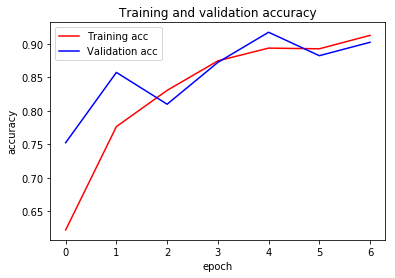

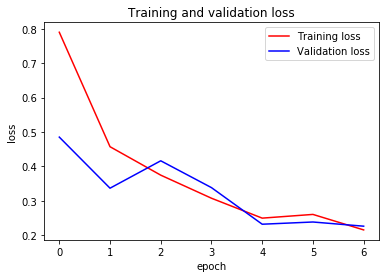

In [22]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Model Evaluation on Testing Set

In [23]:
model.evaluate(test_data, test_labels)

13/13 [==============================] - 0s 10ms/step - loss: 0.2632 - acc: 0.8819


[0.263180136680603, 0.8819095492362976]

Classification metrics

In [24]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[1.08225778e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.55752361e-01 0.00000000e+00]
   [1.95614621e-01 0.00000000e+00 9.88995135e-02 ... 0.00000000e+00
    7.56173015e-01 0.00000000e+00]
   [3.71099412e-01 0.00000000e+00 2.91790903e-01 ... 0.00000000e+00
    1.07022417e+00 0.00000000e+00]
   ...
   [7.44958818e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.52937496e-01 0.00000000e+00]
   [6.74203932e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.81933105e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.10872889e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.67503417e-01 0.00000000e+00]
   [1.47172108e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.46073937e-01 0.00000000e+00]
   [5.80885410e-02 0.00000000e+00 2.80127198e-01 ... 0.00000000e+00
    1.19540596e+00 0.00000000e+00]
   ...
   [1.07736194e+00 0.00000000e+00 4.58051026e-0

In [25]:
animals = ['Cat', 'Dog', 'undefined']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

             precision    recall  f1-score   support

        Cat       0.82      0.97      0.89       199
        Dog       0.96      0.79      0.87       199

avg / total       0.89      0.88      0.88       398



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(len(labels), len(target_names))


Confusion Matrix

In [26]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
#label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [27]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [28]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
#Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


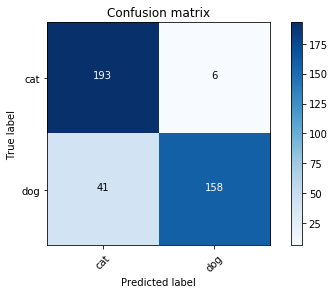

In [29]:
plot_confusion_matrix(confusion_matrix, ['cat', 'dog'])

Normalized confusion matrix


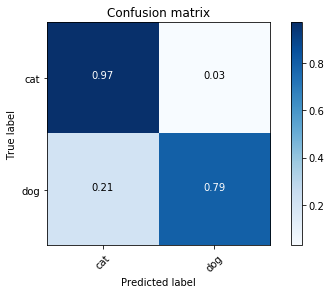

In [30]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['cat', 'dog'],
                     normalize=True)

Testing images on model

In [31]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [32]:
def test_single_image(path):
    animals = ['cat', 'dog']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [85]:
def generateSingleResult(path):
    animals = ['cat', 'dog', "undefined"]
    images = read_image(path)

    bt_prediction = vgg16.predict(images)
    preds = model.predict_proba(bt_prediction)
    print(preds)
    preds = np.where(preds > 0.5, 1, 0)
    print(preds)
    if (preds[0][0] >= 1 and preds[0][1] < 1):
        return (path, animals[0])
    if (preds[0][0] <= 1 and preds[0][1] > 0):
        return (path, animals[1])
    if (preds[0][0] <= 1 and preds[0][1] <= 1):
        return (path, animals[2])
    if (preds[0][0] >= 1 and preds[0][1] >= 1):
        return (path, animals[2])


In [34]:
#path of image that is used for testing
path = 'data/test/cat/cat.810.jpg'
path1 = 'data/test/dog/dog.877.jpg'

[INFO] loading and preprocessing image...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


ID: 0, Label: cat 97.4%
ID: 1, Label: dog 2.6%
Final Decision:
.
..
...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ID: 0, Label: cat


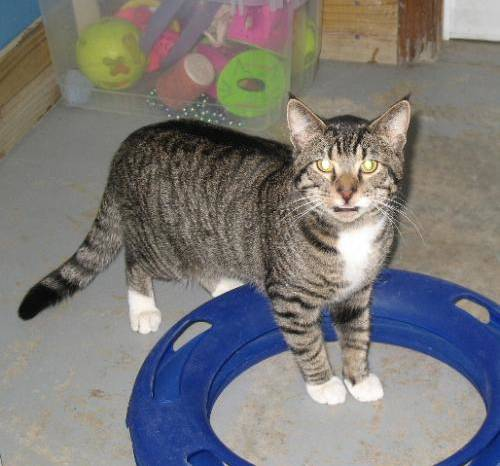

In [35]:
test_single_image(path)
# test_single_image(path1)

In [41]:
import glob
results = []

file_list=os.listdir(r"myData")
for i in file_list:
    result = generateSingleResult("myData/"+i)
    results.append(result)


[INFO] loading and preprocessing image...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[9.9931514e-01 6.8490492e-04]]
[0]
myData/cat.2.jpg cat
[INFO] loading and preprocessing image...
[[0.02183398 0.97816604]]
[1]
myData/dog.0.jpg dog
[INFO] loading and preprocessing image...
[[0.6081969  0.39180315]]
[0]
myData/dog.2.jpg cat
[INFO] loading and preprocessing image...
[[0.9988722  0.00112774]]
[0]
myData/cat.1.jpg cat
[INFO] loading and preprocessing image...
[[0.00412183 0.9958781 ]]
[1]
myData/dog.1.jpg dog
[INFO] loading and preprocessing image...
[[0.8911728 0.1088272]]
[0]
myData/cat.0.jpg cat
[INFO] loading and preprocessing image...
[[0.62737465 0.37262535]]
[0]
myData/dog.3.jpg cat


In [37]:
results

[('myData/cat.2.jpg', 'cat'),
 ('myData/dog.0.jpg', 'dog'),
 ('myData/dog.2.jpg', 'cat'),
 ('myData/cat.1.jpg', 'cat'),
 ('myData/dog.1.jpg', 'dog'),
 ('myData/cat.0.jpg', 'cat'),
 ('myData/dog.3.jpg', 'cat')]